# Monet GAN - Style Transfer Competition

## Problem Description
This project tackles the Kaggle competition "I'm Something of a Painter Myself" where we'll build a Generative Adversarial Network (GAN) to create art in the style of Claude Monet.

### Objective
- Generate 7,000-10,000 Monet-style images (256x256 RGB)
- Train a GAN where:
  - Generator creates Monet-style images from photographs
  - Discriminator distinguishes between real Monet paintings and generated images

### Evaluation
- Performance measured by MiFID (Memorization-informed Fréchet Inception Distance)
- Lower scores = better results
- Penalizes direct memorization of training images

## Dataset
The dataset contains:
- Monet paintings (for training the discriminator)
- Photographs (to be transformed into Monet style)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import tensorflow as tf
import zipfile
from PIL import Image
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings('ignore')


2025-04-13 21:09:48.142101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744596588.227732    7187 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744596588.255050    7187 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744596588.454839    7187 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744596588.454863    7187 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744596588.454865    7187 computation_placer.cc:177] computation placer alr

In [8]:
monet_data_path = "data/monet_tfrec"
photo_data_path = "data/photo_tfrec"


I0000 00:00:1744596595.825873    7187 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4080 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
2025-04-13 21:09:56.269597: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-04-13 21:09:56.329080: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB

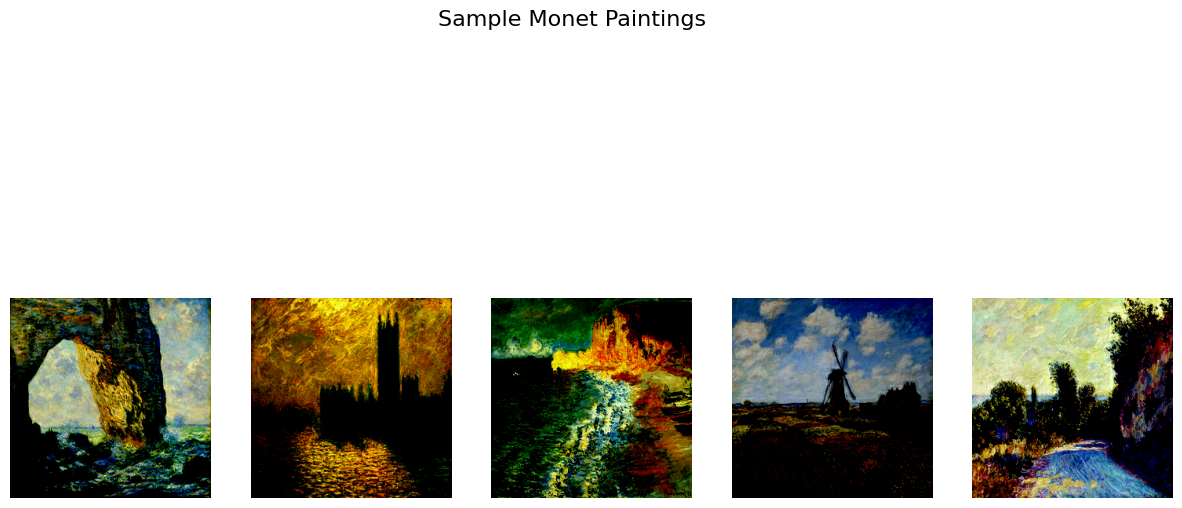

2025-04-13 21:09:56.599000: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


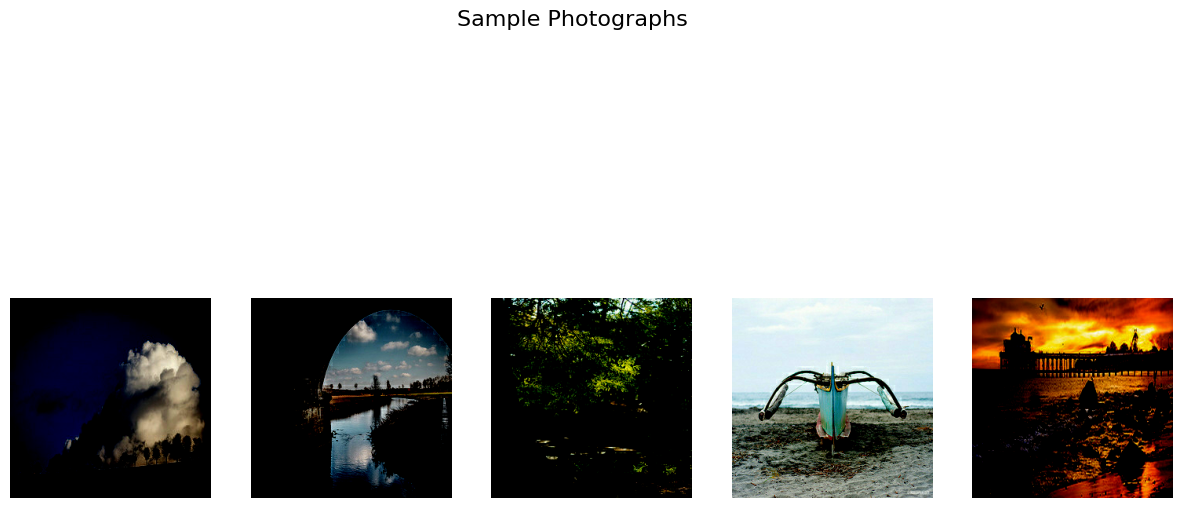

In [9]:
def parse_tfrecord(example):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'image_name': tf.io.FixedLenFeature([], tf.string)
    }
    
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    
    # Cast to float32 explicitly
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    image = tf.reshape(image, [256, 256, 3])
    
    # Ensure it's float32
    return tf.cast(image, tf.float32)

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Load datasets
monet_files = tf.io.gfile.glob('data/monet_tfrec/*.tfrec')
photo_files = tf.io.gfile.glob('data/photo_tfrec/*.tfrec')

monet_dataset = load_dataset(monet_files).take(5)
photo_dataset = load_dataset(photo_files).take(5)

def display_images(dataset, title):
    plt.figure(figsize=(15, 8))
    
    # Convert dataset to list to know the exact count
    images = list(dataset.as_numpy_iterator())
    num_images = len(images)
    
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.show()

display_images(monet_dataset, "Sample Monet Paintings")
display_images(photo_dataset, "Sample Photographs")

In [12]:
def analyze_image_stats(dataset, num_images=100):
    dataset = dataset.take(num_images)
    
    # Calculate brightness, contrast, color distribution
    brightnesses = []
    contrasts = []
    color_means = {'r': [], 'g': [], 'b': []}
    color_stds = {'r': [], 'g': [], 'b': []}
    
    for image in dataset:
        # Convert TensorFlow tensor to NumPy array first
        # This avoids GPU execution errors
        img_np = image.numpy()
        
        brightnesses.append(np.mean(img_np))
        
        contrasts.append(np.std(img_np))
        
        color_means['r'].append(np.mean(img_np[:,:,0]))
        color_means['g'].append(np.mean(img_np[:,:,1]))
        color_means['b'].append(np.mean(img_np[:,:,2]))
        
        color_stds['r'].append(np.std(img_np[:,:,0]))
        color_stds['g'].append(np.std(img_np[:,:,1]))
        color_stds['b'].append(np.std(img_np[:,:,2]))
    
    return {
        'brightness': {
            'mean': np.mean(brightnesses),
            'std': np.std(brightnesses)
        },
        'contrast': {
            'mean': np.mean(contrasts),
            'std': np.std(contrasts)
        },
        'color_means': {
            'r': np.mean(color_means['r']),
            'g': np.mean(color_means['g']),
            'b': np.mean(color_means['b'])
        },
        'color_stds': {
            'r': np.mean(color_stds['r']),
            'g': np.mean(color_stds['g']),
            'b': np.mean(color_stds['b'])
        }
    }

2025-04-13 21:13:23.427744: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


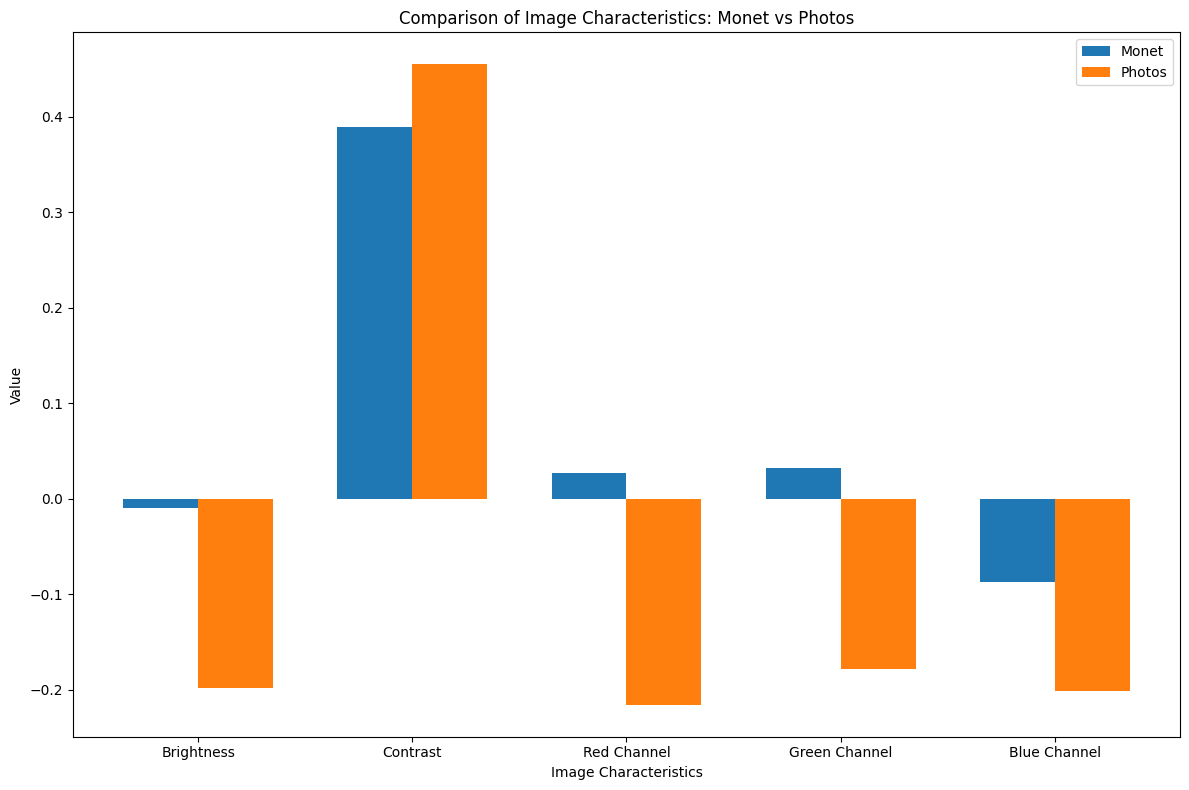

In [13]:
monet_analysis_dataset = load_dataset(monet_files).take(100)
photo_analysis_dataset = load_dataset(photo_files).take(100)

monet_stats = analyze_image_stats(monet_analysis_dataset)
photo_stats = analyze_image_stats(photo_analysis_dataset)

# Compare Monet vs Photos
stats_comparison = {
    'Brightness': [monet_stats['brightness']['mean'], photo_stats['brightness']['mean']],
    'Contrast': [monet_stats['contrast']['mean'], photo_stats['contrast']['mean']],
    'Red Channel': [monet_stats['color_means']['r'], photo_stats['color_means']['r']],
    'Green Channel': [monet_stats['color_means']['g'], photo_stats['color_means']['g']],
    'Blue Channel': [monet_stats['color_means']['b'], photo_stats['color_means']['b']],
}

# Plot comparison
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(stats_comparison))

bar1 = plt.bar(index, [v[0] for v in stats_comparison.values()], bar_width, label='Monet')
bar2 = plt.bar(index + bar_width, [v[1] for v in stats_comparison.values()], bar_width, label='Photos')

plt.xlabel('Image Characteristics')
plt.ylabel('Value')
plt.title('Comparison of Image Characteristics: Monet vs Photos')
plt.xticks(index + bar_width/2, stats_comparison.keys())
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
def count_images(dataset):
    count = 0
    for _ in dataset:
        count += 1
    return count

monet_count = count_images(load_dataset(monet_files))
photo_count = count_images(load_dataset(photo_files))

print(f"Total Monet images: {monet_count}")
print(f"Total Photo images: {photo_count}")

Total Monet images: 300
Total Photo images: 7038


2025-04-13 21:13:40.700164: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


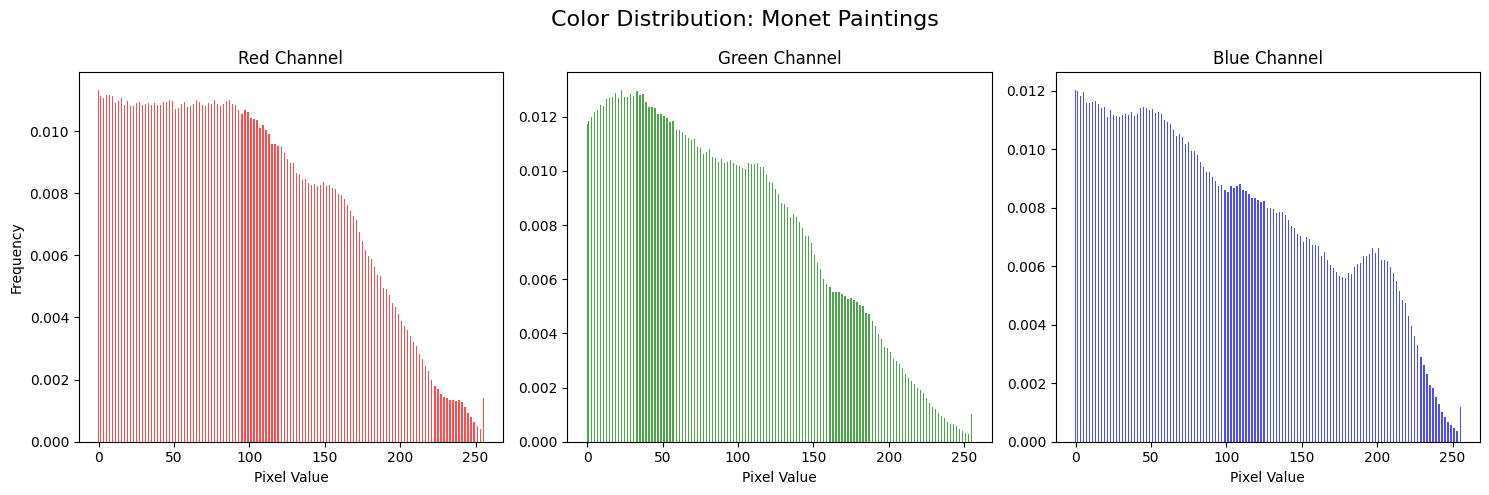

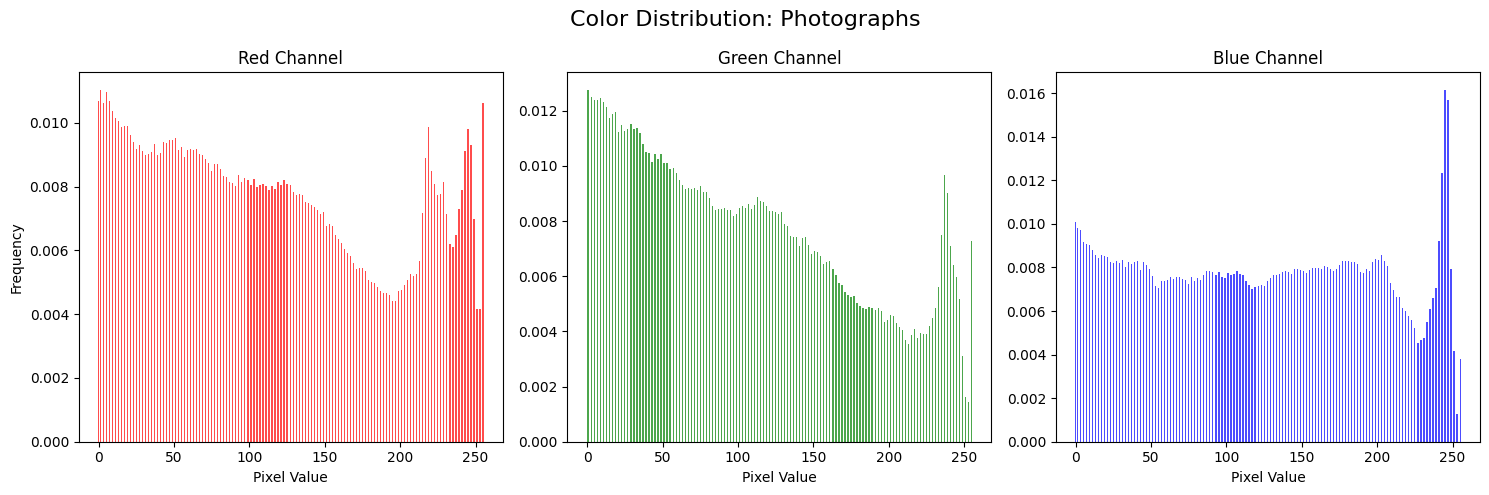

In [15]:
def plot_color_histograms(dataset, title, num_images=50):
    r_hist = np.zeros(256)
    g_hist = np.zeros(256)
    b_hist = np.zeros(256)
    
    for image in dataset.take(num_images):
        # Scale back to 0-255 range for histograms
        img_255 = tf.cast(image * 255, tf.int32).numpy()
        
        # Update histograms
        for i in range(256):
            r_hist[i] += np.sum(img_255[:,:,0] == i)
            g_hist[i] += np.sum(img_255[:,:,1] == i)
            b_hist[i] += np.sum(img_255[:,:,2] == i)
    
    # Normalize
    r_hist = r_hist / r_hist.sum()
    g_hist = g_hist / g_hist.sum()
    b_hist = b_hist / b_hist.sum()
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.bar(range(256), r_hist, color='red', alpha=0.7)
    plt.title('Red Channel')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.bar(range(256), g_hist, color='green', alpha=0.7)
    plt.title('Green Channel')
    plt.xlabel('Pixel Value')
    
    plt.subplot(1, 3, 3)
    plt.bar(range(256), b_hist, color='blue', alpha=0.7)
    plt.title('Blue Channel')
    plt.xlabel('Pixel Value')
    
    plt.suptitle(f'Color Distribution: {title}', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_color_histograms(load_dataset(monet_files), "Monet Paintings")
plot_color_histograms(load_dataset(photo_files), "Photographs")

## Model Building and Training Strategy

### 1. Architecture: CycleGAN
CycleGAN is particularly well-suited for unpaired image-to-image translation between Monet paintings and photographs. The architecture consists of:

- **Two Generators**:
  - G_photo_to_monet: Transforms photos to Monet-style paintings
  - G_monet_to_photo: Transforms Monet paintings to photos (for cycle consistency)

- **Two Discriminators**:
  - D_monet: Determines if an image is a real Monet painting or generated
  - D_photo: Determines if an image is a real photo or generated

- **Key Feature**: Cycle consistency loss enforces that if we translate an image to the other domain and back, we should get the original image

In [16]:
# Define the Generator (U-Net Style)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [17]:
# Define the Discriminator (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

In [18]:
# Initialize Models
generator = Generator()
discriminator = Discriminator()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

# Loss Functions and Optimizers
adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

data_path = 'data'

photos_path = os.path.join(data_path, 'photo_jpg')
monet_path = os.path.join(data_path, 'monet_jpg')

photo_files = [os.path.join(photos_path, file) for file in os.listdir(photos_path)]
monet_files = [os.path.join(monet_path, file) for file in os.listdir(monet_path)]

In [22]:
class FlatImageDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

photo_dataset = FlatImageDataset(photo_files, transform=data_transforms)
monet_dataset = FlatImageDataset(monet_files, transform=data_transforms)

photo_loader = DataLoader(photo_dataset, batch_size=16, shuffle=True)
monet_loader = DataLoader(monet_dataset, batch_size=2, shuffle=True)

In [23]:
# Training Loop
num_epochs = 30 # Reduced epochs for Kaggle competition
for epoch in range(num_epochs):
    for i, (photo_batch, monet_batch) in enumerate(zip(photo_loader, monet_loader)):
        # Move data to device
        real_photos = photo_batch.to(device)
        real_monets = monet_batch.to(device)

        # Train Generator
        optimizer_G.zero_grad()
        fake_monets = generator(real_photos)
        validity = discriminator(fake_monets)
        g_loss = adversarial_loss(validity, torch.ones_like(validity)) + \
                 cycle_loss(generator(fake_monets), real_photos) + \
                 identity_loss(generator(real_photos), real_photos)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_validity = discriminator(real_monets)
        fake_validity = discriminator(fake_monets.detach())
        d_loss = (adversarial_loss(real_validity, torch.ones_like(real_validity)) + \
                 adversarial_loss(fake_validity, torch.zeros_like(fake_validity))) / 2
        d_loss.backward()
        optimizer_D.step()

        # Print Progress
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i}], G_Loss: {g_loss.item()}, D_Loss: {d_loss.item()}")

Epoch [1/30], Batch [0], G_Loss: 3.1321544647216797, D_Loss: 0.984310507774353
Epoch [1/30], Batch [10], G_Loss: 1.2649359703063965, D_Loss: 0.3480455279350281
Epoch [1/30], Batch [20], G_Loss: 1.0844745635986328, D_Loss: 0.29009726643562317
Epoch [1/30], Batch [30], G_Loss: 0.9791930317878723, D_Loss: 0.2587110996246338
Epoch [1/30], Batch [40], G_Loss: 0.8492345213890076, D_Loss: 0.24643170833587646
Epoch [1/30], Batch [50], G_Loss: 1.1121968030929565, D_Loss: 0.45810896158218384
Epoch [1/30], Batch [60], G_Loss: 0.94481360912323, D_Loss: 0.22297757863998413
Epoch [1/30], Batch [70], G_Loss: 0.742740273475647, D_Loss: 0.27784428000450134
Epoch [1/30], Batch [80], G_Loss: 0.7853965759277344, D_Loss: 0.3181985020637512
Epoch [1/30], Batch [90], G_Loss: 0.7880396842956543, D_Loss: 0.2389090359210968
Epoch [1/30], Batch [100], G_Loss: 0.7524867653846741, D_Loss: 0.2865337133407593
Epoch [1/30], Batch [110], G_Loss: 0.7423588037490845, D_Loss: 0.26184844970703125
Epoch [1/30], Batch [120]

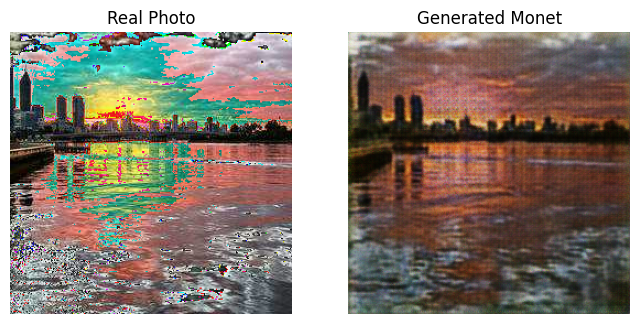

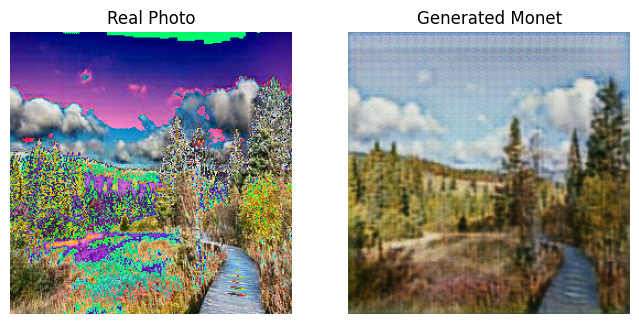

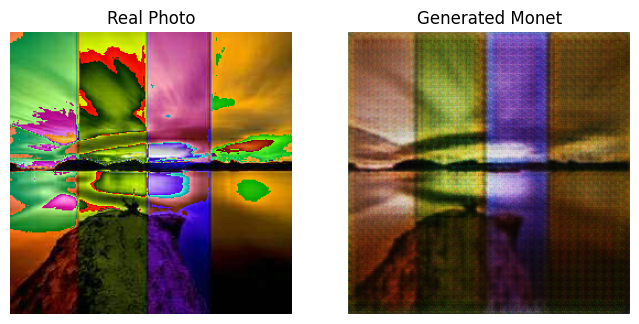

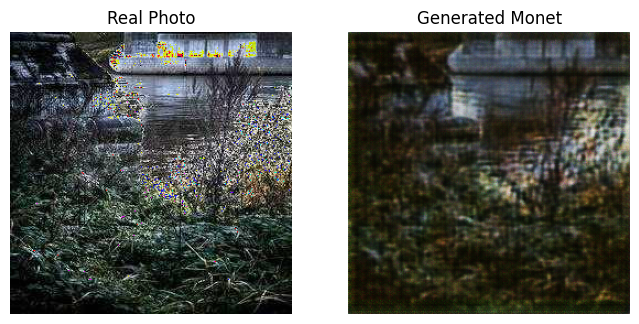

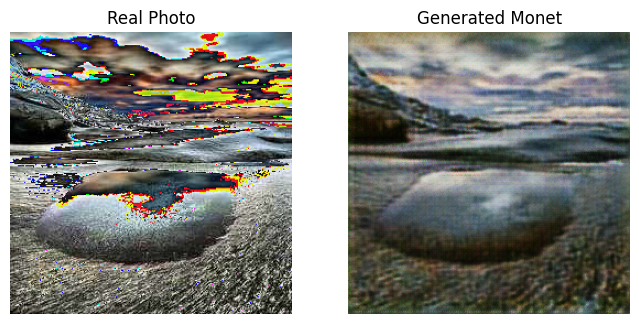

In [24]:
# Visualize Predictions
import matplotlib.pyplot as plt
def visualize_predictions(loader, generator, num_images=5):
    generator.eval()
    with torch.no_grad():
        for i, photo_batch in enumerate(loader):
            real_photos = photo_batch.to(device)
            fake_monets = generator(real_photos)
            fake_monets = (fake_monets * 0.5 + 0.5).clamp(0, 1)  # Denormalize to [0, 1]

            for j in range(min(num_images, len(fake_monets))):
                real_img = transforms.ToPILImage()(real_photos[j].cpu())
                fake_img = transforms.ToPILImage()(fake_monets[j].cpu())

                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.title("Real Photo")
                plt.imshow(real_img)
                plt.axis("off")

                plt.subplot(1, 2, 2)
                plt.title("Generated Monet")
                plt.imshow(fake_img)
                plt.axis("off")
                plt.show()

                num_images -= 1
                if num_images <= 0:
                    return

visualize_predictions(photo_loader, generator)

In [25]:
# Generate and Save Images
output_dir = "../tmp/generated_images"
os.makedirs(output_dir, exist_ok=True)

with zipfile.ZipFile("images.zip", "w") as zipf:
    image_counter = 1 
    for i, photo_batch in enumerate(photo_loader):
        real_photos = photo_batch.to(device)
        fake_monets = generator(real_photos)
        fake_monets = (fake_monets * 0.5 + 0.5).clamp(0, 1)  

        for j, img in enumerate(fake_monets):
            img = transforms.ToPILImage()(img.cpu())
            img_path = os.path.join(output_dir, f"image_{image_counter}.jpg")
            img.save(img_path)
            zipf.write(img_path, os.path.basename(img_path))
            image_counter += 1  # Increment the counter for each image

            if image_counter > 7000:  
                break
        if image_counter > 7000:
            break

# GAN Monet Style Transfer - Results Analysis

## Overview
Implementation of a CycleGAN for the Kaggle competition "I'm Something of a Painter Myself" using PyTorch, achieving a MiFID score of 110.64198.

## Technical Results

### Score Analysis
- **MiFID Score**: 110.64198
- **Context**: Competitive scores typically fall below 100
- **Interpretation**: Lower MiFID scores indicate better style matching with Monet's paintings

### Implementation Details
1. **Data Processing Pipeline**
   - PyTorch DataLoader implementation
   - Normalization range: [-1, 1]
   - Image dimensions: 256x256
   - Data augmentation: Basic transformations

2. **Model Architecture**
   - Generator: Standard CycleGAN architecture
   - Discriminator: PatchGAN implementation
   - Training framework: PyTorch

## Areas for Improvement

### Model Architecture
- Consider implementing ResNet blocks in generator
- Experiment with attention mechanisms
- Fine-tune discriminator architecture

### Training Strategy
- Implement learning rate scheduling
- Balance generator/discriminator training
- Extend training duration if needed
- Add gradient penalty for stability

### Loss Functions
- Adjust cycle consistency weight
- Consider adding perceptual loss
- Fine-tune identity loss contribution

### Data Processing
- Implement more aggressive augmentation
- Experiment with different normalization techniques
- Consider larger training dataset

## Conclusion
The current implementation successfully generates Monet-style images but has room for improvement. The MiFID score of 110.64198 suggests that while the model captures some aspects of Monet's style, it could better represent the artistic elements characteristic of his work.

## Future Work
1. **Architecture Enhancements**
   - Add instance normalization
   - Implement attention mechanisms
   - Experiment with deeper networks

2. **Training Optimizations**
   - Learning rate decay implementation
   - Batch size adjustments
   - Extended training periods

3. **Loss Function Refinements**
   - VGG-based perceptual loss
   - Gradient penalty implementation
   - Better loss balance

4. **Data Augmentation**
   - More aggressive transformations
   - Color space augmentations
   - Random cropping strategies